In [2]:
%matplotlib inline

In [3]:
import os

In [4]:
import numpy as np
import pandas as pd
from scipy import interpolate

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

In [6]:
%run config.py

# Smooth

In [102]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

# Load data

In [7]:
vgg_filename = os.path.join(DATA_DIR, 'paper_data/run_softmax_pansharpen_vgg_for_ws_big_objects,tag_jaccard_mean-val.csv')
tiramisu_filename = os.path.join(DATA_DIR, 'paper_data/run_softmax_pansharpen_tiramisu_big_objects,tag_jaccard_mean-val.csv')

In [9]:
vgg_data = pd.read_csv(vgg_filename)

In [22]:
vgg_data.head()

,Wall time,Step,Value
0,1.489941e+09,100,0.007677
1,1.489941e+09,200,0.007596
2,1.489941e+09,300,0.004388
3,1.489941e+09,400,0.011417
4,1.489941e+09,500,0.023185


In [23]:
vgg_data.shape

(592, 3)

In [12]:
tiramisu_data = pd.read_csv(tiramisu_filename)

In [13]:
tiramisu_data.head()

,Wall time,Step,Value
0,1.489109e+09,125,0.005604
1,1.489109e+09,250,0.005545
2,1.489109e+09,375,0.023641
3,1.489109e+09,500,0.058844
4,1.489109e+09,625,0.089720


In [24]:
tiramisu_data.shape

(120, 3)

## Smooth

In [174]:
x_min = max(vgg_data.Step.min(), tiramisu_data.Step.min())
x_max = min(vgg_data.Step.max(), tiramisu_data.Step.max())
x_space = np.linspace(x_min, x_max, 100)

vgg_y_space_f = interpolate.interp1d(vgg_data.Step, vgg_data.Value, kind='quadratic')
tiramisu_y_space_f = interpolate.interp1d(tiramisu_data.Step, tiramisu_data.Value, kind='quadratic')

vgg_y_space = vgg_y_space_f(x_space)
tiramisu_y_space = tiramisu_y_space_f(x_space)

# vgg_spline = interpolate.CubicSpline(vgg_data.Step, vgg_data.Value)
# tiramisu_spline = interpolate.CubicSpline(tiramisu_data.Step, tiramisu_data.Value)

vgg_y_smooth = savitzky_golay(vgg_y_space, 31, 1)
tiramisu_y_smooth = savitzky_golay(tiramisu_y_space, 31, 1)

In [175]:
x_min, x_max

(125, 15000)

## Plot

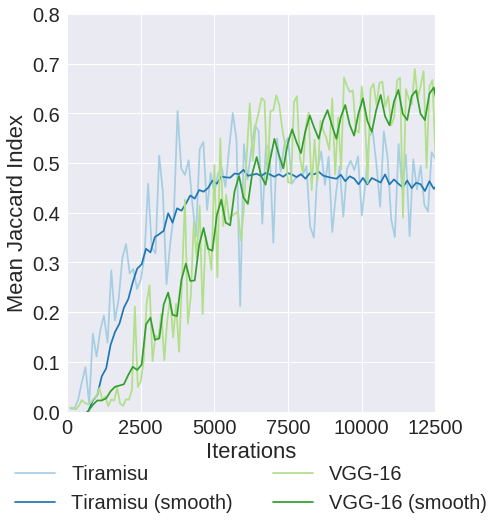

In [176]:
fig, ax = plt.subplots(figsize=(7, 7))

colors = sns.color_palette("Paired", 4)

ax.plot(tiramisu_data.Step, tiramisu_data.Value, color=colors[0], label='Tiramisu')
ax.plot(x_space, tiramisu_y_smooth, color=colors[1], label='Tiramisu (smooth)')

ax.plot(vgg_data.Step, vgg_data.Value, color=colors[2], label='VGG-16')
ax.plot(x_space, vgg_y_smooth, color=colors[3], label='VGG-16 (smooth)')


# vgg_smooth_y = [float(vgg_smooth(x)) for x in x_space]

ax.set_xlabel('Iterations')
ax.set_ylabel('Mean Jaccard Index')

ax.set_xlim(0, 12500)
ax.set_ylim(0, 0.8)

ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.3))

fig.tight_layout(pad=1)

plt.savefig('/home/aromanov/projects/kaggle_dstl_satellite/data/paper_data/tiramisu_vgg_learning.pdf', bbox_inches='tight')

# Areas-Jaccard graph

In [7]:
areas_jaccard_filename = os.path.join(DATA_DIR, 'paper_data', 'areas_jaccard.csv')

In [8]:
areas_jaccard_data = pd.read_csv(areas_jaccard_filename, delimiter='\t')

In [9]:
areas_jaccard_data

,Class,Min,Max,Median,Jaccard
0,Buildings,0.0067,40015.210,441.341,0.784
1,Manmade struct,0.0009,20916.284,66.901,0.604
2,Road,668.6613,484753.943,105557.383,0.863
3,Track,0.0360,1035099.485,2359.295,0.714
4,Trees,0.0000,689473.705,276.645,0.818
5,Crops,0.0966,5246407.398,60442.565,0.942
6,Waterway,55.3698,775557.067,934.856,0.991
7,Standing water,0.1014,53817.825,119.165,0.843
8,Vehicle Large,4.1127,864.653,107.993,0.827
9,Vehicle Small,0.0353,968.439,23.169,0.646


## Plot

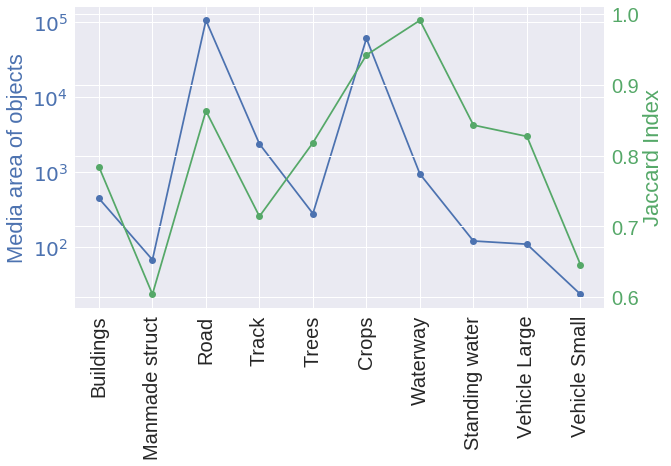

In [28]:
fig, ax = plt.subplots(figsize=(10, 7))

x_space = np.arange(len(areas_jaccard_data.Class))
colors = sns.color_palette()

ax.semilogy(x_space, areas_jaccard_data.Median, label='Median Area', color=colors[0], marker='o')
ax.set_ylabel('Media area of objects', color=colors[0])
ax.tick_params('y', colors=colors[0])

ax2 = ax.twinx()
ax2.plot(x_space, areas_jaccard_data.Jaccard, label='Jaccard', color=colors[1], marker='o')
ax2.set_ylabel('Jaccard Index', color=colors[1])
ax2.tick_params('y', colors=colors[1])

ax.set_xticks(x_space)
ax.set_xticklabels(areas_jaccard_data.Class, rotation=90)


# ax.set_xlabel('Iterations')
# ax.set_ylabel('Mean Jaccard Index')

# ax.set_xlim(0, 12500)
# ax.set_ylim(0, 0.8)

# ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.3))

fig.tight_layout()

plt.savefig('/home/aromanov/projects/kaggle_dstl_satellite/data/paper_data/area_jaccard.pdf', bbox_inches='tight')